# Python - HW4 - Template

## Zheng Nan Yang

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline
%load_ext sql

C:\Users\AndrewYang\Anaconda3\envs\mfe-preprogram\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


### Import Data

In [2]:
conn = sqlite3.connect('data/data.db')

Defining parameters

In [3]:
#Parameters
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-11'

In [4]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', conn)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [5]:
prices

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-11-05 00:00:00,61188.45,61531.65,61140.22,61444.50,232.054183,1.423677e+07,BTC,BTC
2021-11-05 01:00:00,61444.49,61537.09,60870.00,60920.77,343.899671,2.105516e+07,BTC,BTC
2021-11-05 02:00:00,60920.68,61840.00,60896.37,61820.72,387.049829,2.374667e+07,BTC,BTC
2021-11-05 03:00:00,61820.72,61960.00,61678.53,61678.53,370.385830,2.290663e+07,BTC,BTC
2021-11-05 04:00:00,61678.53,62364.98,61678.53,62247.05,424.671468,2.637991e+07,BTC,BTC
...,...,...,...,...,...,...,...,...
2021-11-10 19:00:00,68638.47,68656.48,67592.06,67782.03,972.965320,6.622890e+07,BTC,BTC
2021-11-10 20:00:00,67781.42,68010.62,66559.37,66640.96,1006.991010,6.783128e+07,BTC,BTC
2021-11-10 21:00:00,66640.96,67041.51,65100.00,65835.00,2119.548755,1.404769e+08,BTC,BTC


### Calculate the hourly return by timestamp

In [6]:
prices['log_return'] = np.log(prices['close'] / prices['close'].shift(1))

In [7]:
prices

,open,high,low,close,volume,volumeUSD,token,chain,log_return
ts,,,,,,,,,
2021-11-05 00:00:00,61188.45,61531.65,61140.22,61444.50,232.054183,1.423677e+07,BTC,BTC,NaN
2021-11-05 01:00:00,61444.49,61537.09,60870.00,60920.77,343.899671,2.105516e+07,BTC,BTC,-0.008560
2021-11-05 02:00:00,60920.68,61840.00,60896.37,61820.72,387.049829,2.374667e+07,BTC,BTC,0.014664
2021-11-05 03:00:00,61820.72,61960.00,61678.53,61678.53,370.385830,2.290663e+07,BTC,BTC,-0.002303
2021-11-05 04:00:00,61678.53,62364.98,61678.53,62247.05,424.671468,2.637991e+07,BTC,BTC,0.009175
...,...,...,...,...,...,...,...,...,...
2021-11-10 19:00:00,68638.47,68656.48,67592.06,67782.03,972.965320,6.622890e+07,BTC,BTC,-0.012573
2021-11-10 20:00:00,67781.42,68010.62,66559.37,66640.96,1006.991010,6.783128e+07,BTC,BTC,-0.016978
2021-11-10 21:00:00,66640.96,67041.51,65100.00,65835.00,2119.548755,1.404769e+08,BTC,BTC,-0.012168


### Calculate the hourly volatility 

In [8]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [9]:
prices['volatility'] = vol_ohlc(prices)
prices

,open,high,low,close,volume,volumeUSD,token,chain,log_return,volatility
ts,,,,,,,,,,
2021-11-05 00:00:00,61188.45,61531.65,61140.22,61444.50,232.054183,1.423677e+07,BTC,BTC,NaN,NaN
2021-11-05 01:00:00,61444.49,61537.09,60870.00,60920.77,343.899671,2.105516e+07,BTC,BTC,-0.008560,NaN
2021-11-05 02:00:00,60920.68,61840.00,60896.37,61820.72,387.049829,2.374667e+07,BTC,BTC,0.014664,NaN
2021-11-05 03:00:00,61820.72,61960.00,61678.53,61678.53,370.385830,2.290663e+07,BTC,BTC,-0.002303,NaN
2021-11-05 04:00:00,61678.53,62364.98,61678.53,62247.05,424.671468,2.637991e+07,BTC,BTC,0.009175,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-11-10 19:00:00,68638.47,68656.48,67592.06,67782.03,972.965320,6.622890e+07,BTC,BTC,-0.012573,0.127073
2021-11-10 20:00:00,67781.42,68010.62,66559.37,66640.96,1006.991010,6.783128e+07,BTC,BTC,-0.016978,0.138592
2021-11-10 21:00:00,66640.96,67041.51,65100.00,65835.00,2119.548755,1.404769e+08,BTC,BTC,-0.012168,0.167518


### Calculate maximum drawdown up to that hour for each hour

In [10]:
#Max drawdown percentage 
prices['max_drawdown_pct'] = (prices['low'].cummin() - prices['high'].cummax()) / prices['high'].cummax()
prices

,open,high,low,close,volume,volumeUSD,token,chain,log_return,volatility,max_drawdown_pct
ts,,,,,,,,,,,
2021-11-05 00:00:00,61188.45,61531.65,61140.22,61444.50,232.054183,1.423677e+07,BTC,BTC,NaN,NaN,-0.006361
2021-11-05 01:00:00,61444.49,61537.09,60870.00,60920.77,343.899671,2.105516e+07,BTC,BTC,-0.008560,NaN,-0.010840
2021-11-05 02:00:00,60920.68,61840.00,60896.37,61820.72,387.049829,2.374667e+07,BTC,BTC,0.014664,NaN,-0.015686
2021-11-05 03:00:00,61820.72,61960.00,61678.53,61678.53,370.385830,2.290663e+07,BTC,BTC,-0.002303,NaN,-0.017592
2021-11-05 04:00:00,61678.53,62364.98,61678.53,62247.05,424.671468,2.637991e+07,BTC,BTC,0.009175,NaN,-0.023971
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10 19:00:00,68638.47,68656.48,67592.06,67782.03,972.965320,6.622890e+07,BTC,BTC,-0.012573,0.127073,-0.128623
2021-11-10 20:00:00,67781.42,68010.62,66559.37,66640.96,1006.991010,6.783128e+07,BTC,BTC,-0.016978,0.138592,-0.128623
2021-11-10 21:00:00,66640.96,67041.51,65100.00,65835.00,2119.548755,1.404769e+08,BTC,BTC,-0.012168,0.167518,-0.128623


### Plotting

plot in a 2x2 grid:
* hourly return
* hourly vol
* maximum drawdown
* close prices
* color each day on the graph

In [11]:
def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.terrain(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

    if events is not None:
        ymin, ymax = ax.get_ylim()
        text_pos = 1
        
        for idx, row in events.loc[data.index[0]:data.index[-1]].iterrows():
            if row.impact == 1:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.2', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.2')    
            elif row.impact == 2:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.6', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.6')

In [12]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

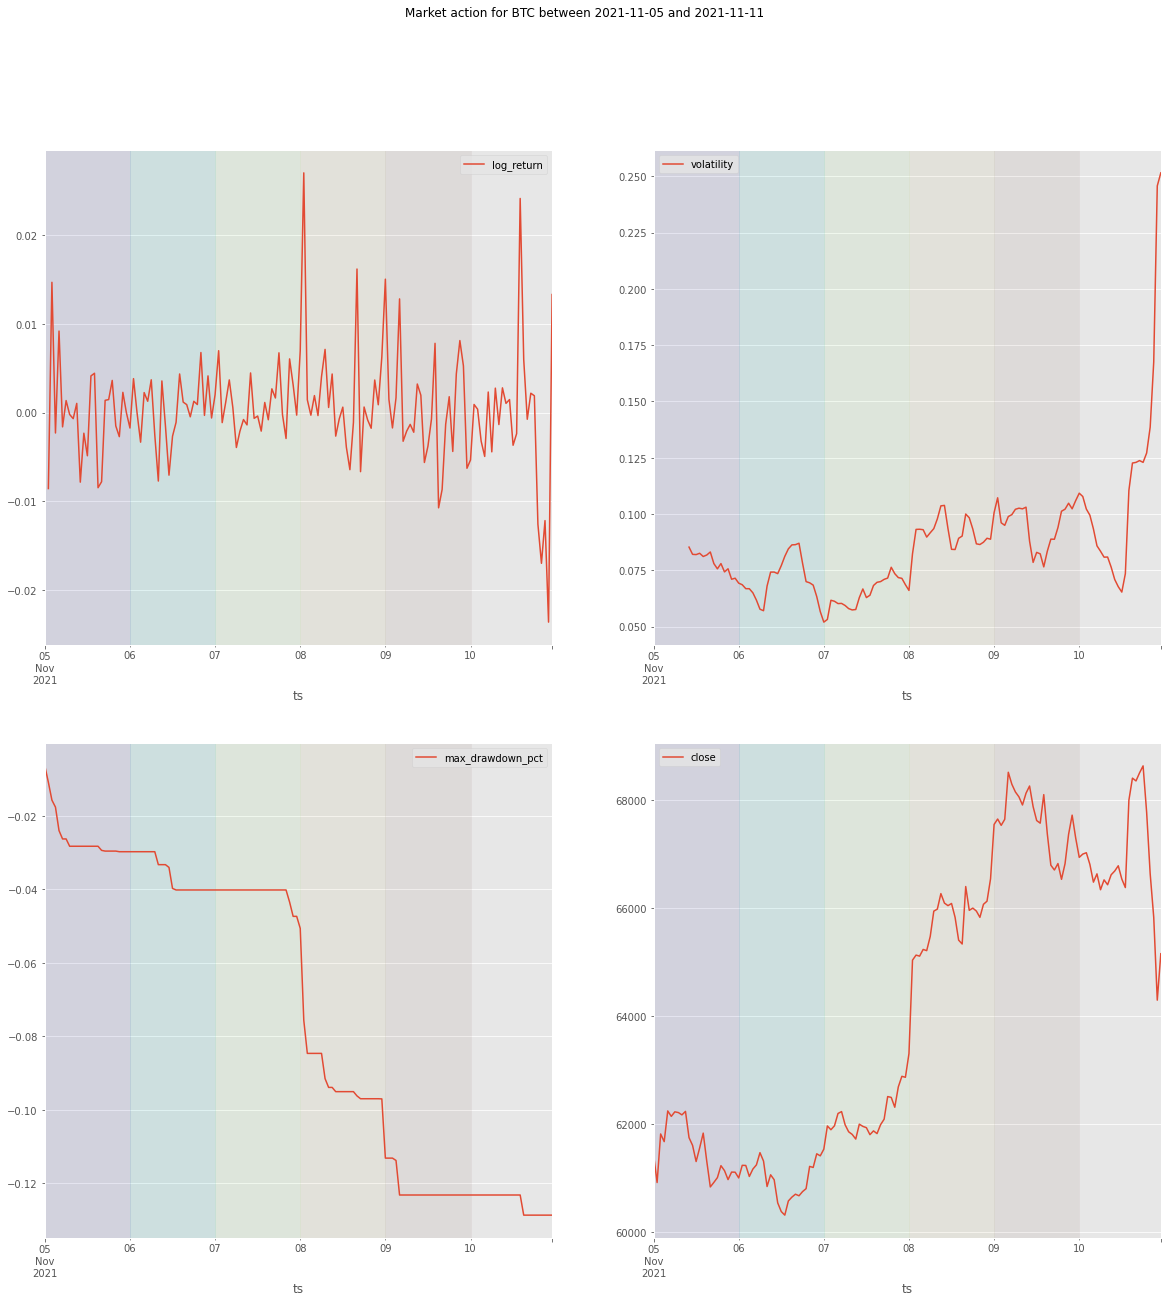

In [13]:
series_plot(prices[['log_return']], ax=ax[0, 0])
series_plot(prices[['volatility']], ax=ax[0, 1])
series_plot(prices[['max_drawdown_pct']], ax=ax[1, 0])
series_plot(prices[['close']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

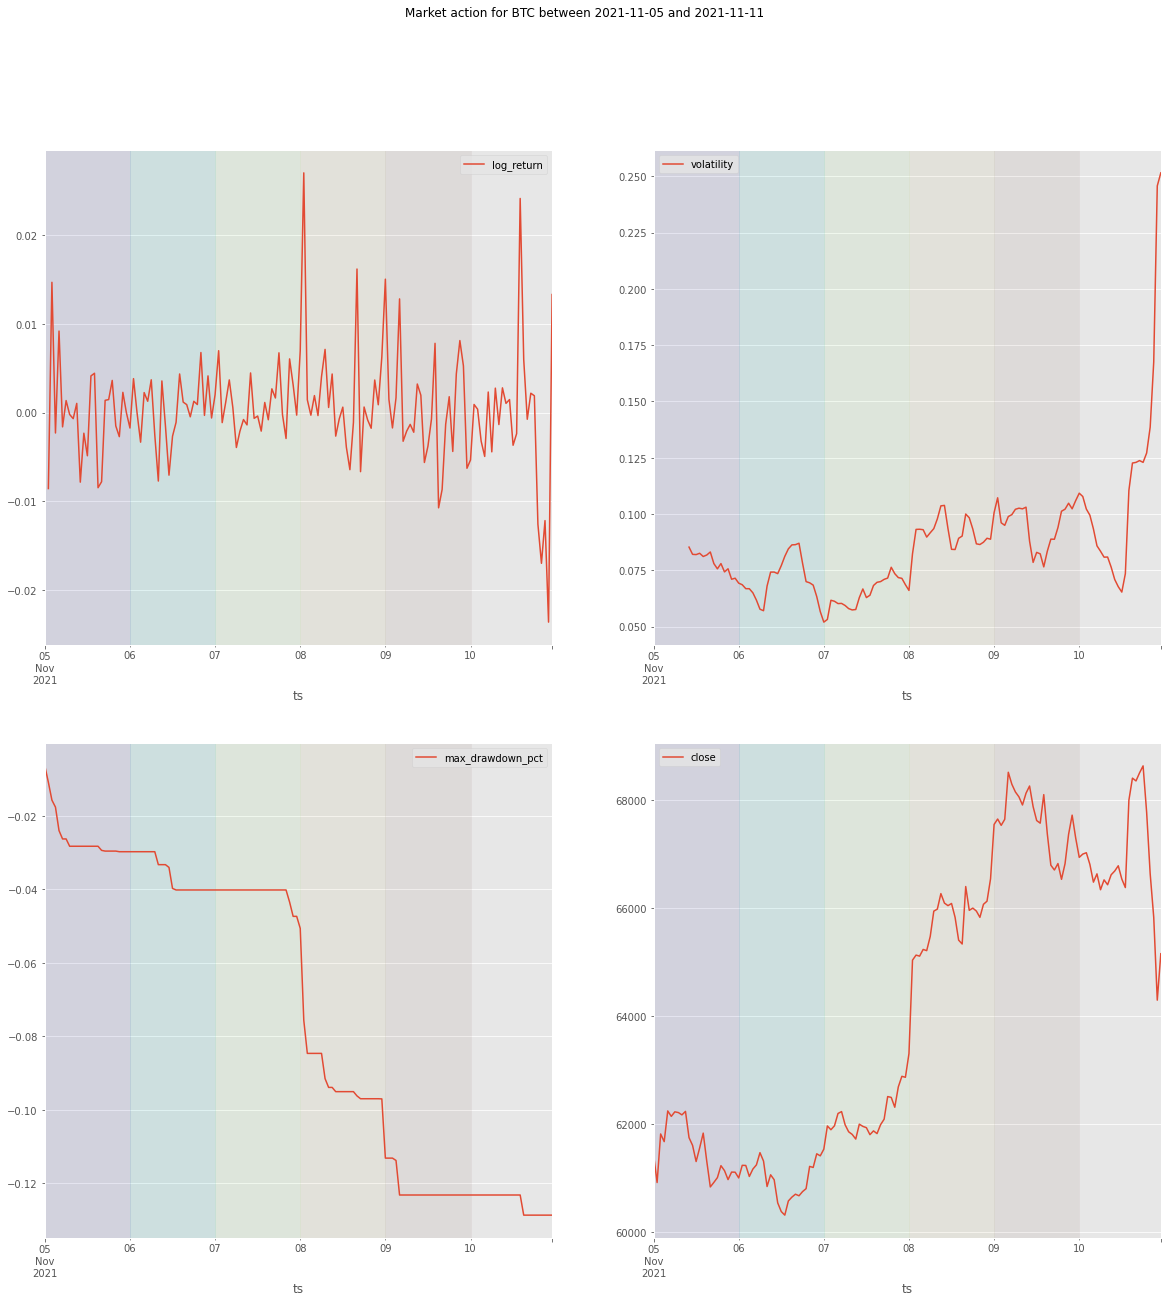

In [14]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)